# Training a Jet Tagging with **DNN** 

---
In this notebook, we perform a Jet identification task using a multiclass classifier based on a 
Dense Neural Network (DNN), also called multi-layer perceptron (MLP). The problem consists on identifying a given jet as a quark, a gluon, a W, a Z, or a top,
based on set of physics-motivated high-level features.

For details on the physics problem, see https://arxiv.org/pdf/1804.06913.pdf 

For details on the dataset, see Notebook1

---

In [1]:
import os
import h5py
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Preparation of the training and validation samples

---
In order to import the dataset, we now
- clone the dataset repository (to import the data in Colab)
- load the h5 files in the data/ repository
- extract the data we need: a target and jet features

To type shell commands, we start the command line with !

**nb, if you are running locally and you have already downloaded the datasets you can skip the cell below and, if needed, change the paths later to point to the folder with your previous download of the datasets.**

In [2]:
# ! curl https://cernbox.cern.ch/s/6Ec5pGFEpFWeH6S/download -o Data-MLtutorial.tar.gz
# ! tar -xvzf Data-MLtutorial.tar.gz 
# ! ls Data-MLtutorial/JetDataset/
# ! rm Data-MLtutorial.tar.gz 

# Dataset Exploration

In [3]:
# let's open the file
data_dir = '../Data-MLtutorial/JetDataset/'
fileIN = data_dir+'jetImage_7_100p_30000_40000.h5'
f = h5py.File(fileIN)
# and see what it contains
print(list(f.keys()))

['jetConstituentList', 'jetFeatureNames', 'jetImage', 'jetImageECAL', 'jetImageHCAL', 'jets', 'particleFeatureNames']


*   'jetImage' ,' jetImageECAL' and 'jetImageHCAL' contains the image representation of the jets  . We will not use them today but build our point cloud from the other information.
*   'jetConstituentList' is the list of particles cointained in the jet. For each particle, a list of relevant quantities is stored. This is the dataset we will consider in this notebook.
*   'particleFeatureNames' is the list of the names corresponding to the quantities contained in 'jetConstituentList'
*   'jets' is the list of jets with the high-level jet features stored. We will only use jet ID from it, indecies [-6:-1]
*   'jetFeatureNames' is the list of the names corresponding to the quantities contained in 'jets'. These quantities are build using physics knowledge and correspond to high-level infromation and features per graph (as opposed to per node)

The first 100 highest transverse momentum $p_T$ particles are considered for each jet.



In [4]:
target = np.array([])
AllFeatures = np.array([])

# we cannot load all data on Colab. So we just take a few files
datafiles = ['Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
             'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']
# if you are running locallt, you can use the full dataset doing
# for fileIN in glob.glob("tutorials/HiggsSchool/data/*h5"):
for fileIN in datafiles:
    print("Appending %s" %fileIN)
    f = h5py.File(f'../{fileIN}')
    myAllFeatures = np.array(f.get("jets")[:,4:-6])
    mytarget = np.array(f.get('jets')[0:,-6:-1])
    AllFeatures = np.concatenate([AllFeatures, myAllFeatures], axis=0) if AllFeatures.size else myAllFeatures
    target = np.concatenate([target, mytarget], axis=0) if target.size else mytarget
    f.close()
print(target.shape, AllFeatures.shape)

# let's see what we have
f = h5py.File(f'../{datafiles[-1]}')
features_list = list(f.get("jetFeatureNames"))[4:-6]
f.close()
print(features_list)
labels = ['gluon', 'quark', 'W', 'Z', 'top']

Appending Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Appending Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
(50000, 5) (50000, 49)
[b'j_tau1_b1', b'j_tau2_b1', b'j_tau3_b1', b'j_tau1_b2', b'j_tau2_b2', b'j_tau3_b2', b'j_tau32_b1', b'j_tau32_b2', b'j_zlogz', b'j_c1_b0', b'j_c1_b1', b'j_c1_b2', b'j_c2_b1', b'j_c2_b2', b'j_d2_b1', b'j_d2_b2', b'j_d2_a1_b1', b'j_d2_a1_b2', b'j_m2_b1', b'j_m2_b2', b'j_n2_b1', b'j_n2_b2', b'j_tau1_b1_mmdt', b'j_tau2_b1_mmdt', b'j_tau3_b1_mmdt', b'j_tau1_b2_mmdt', b'j_tau2_b2_mmdt', b'j_tau3_b2_mmdt', b'j_tau32_b1_mmdt', b'j_tau32_b2_mmdt', b'j_c1_b0_mmdt', b'j_c1_b1_mmdt', b'j_c1_b2_mmdt', b'j_c2_b1_mmdt', b'j_c2_b2_mmdt', b'j_d2_b1_mmdt', b'j_d2_b2_mmdt', b'j_d2_a1_b1_mmdt', b'j_d2_a1_b2_mmdt', b'j_m2_b1_mmdt', b'j_m2_b2_mmdt', b'j_n

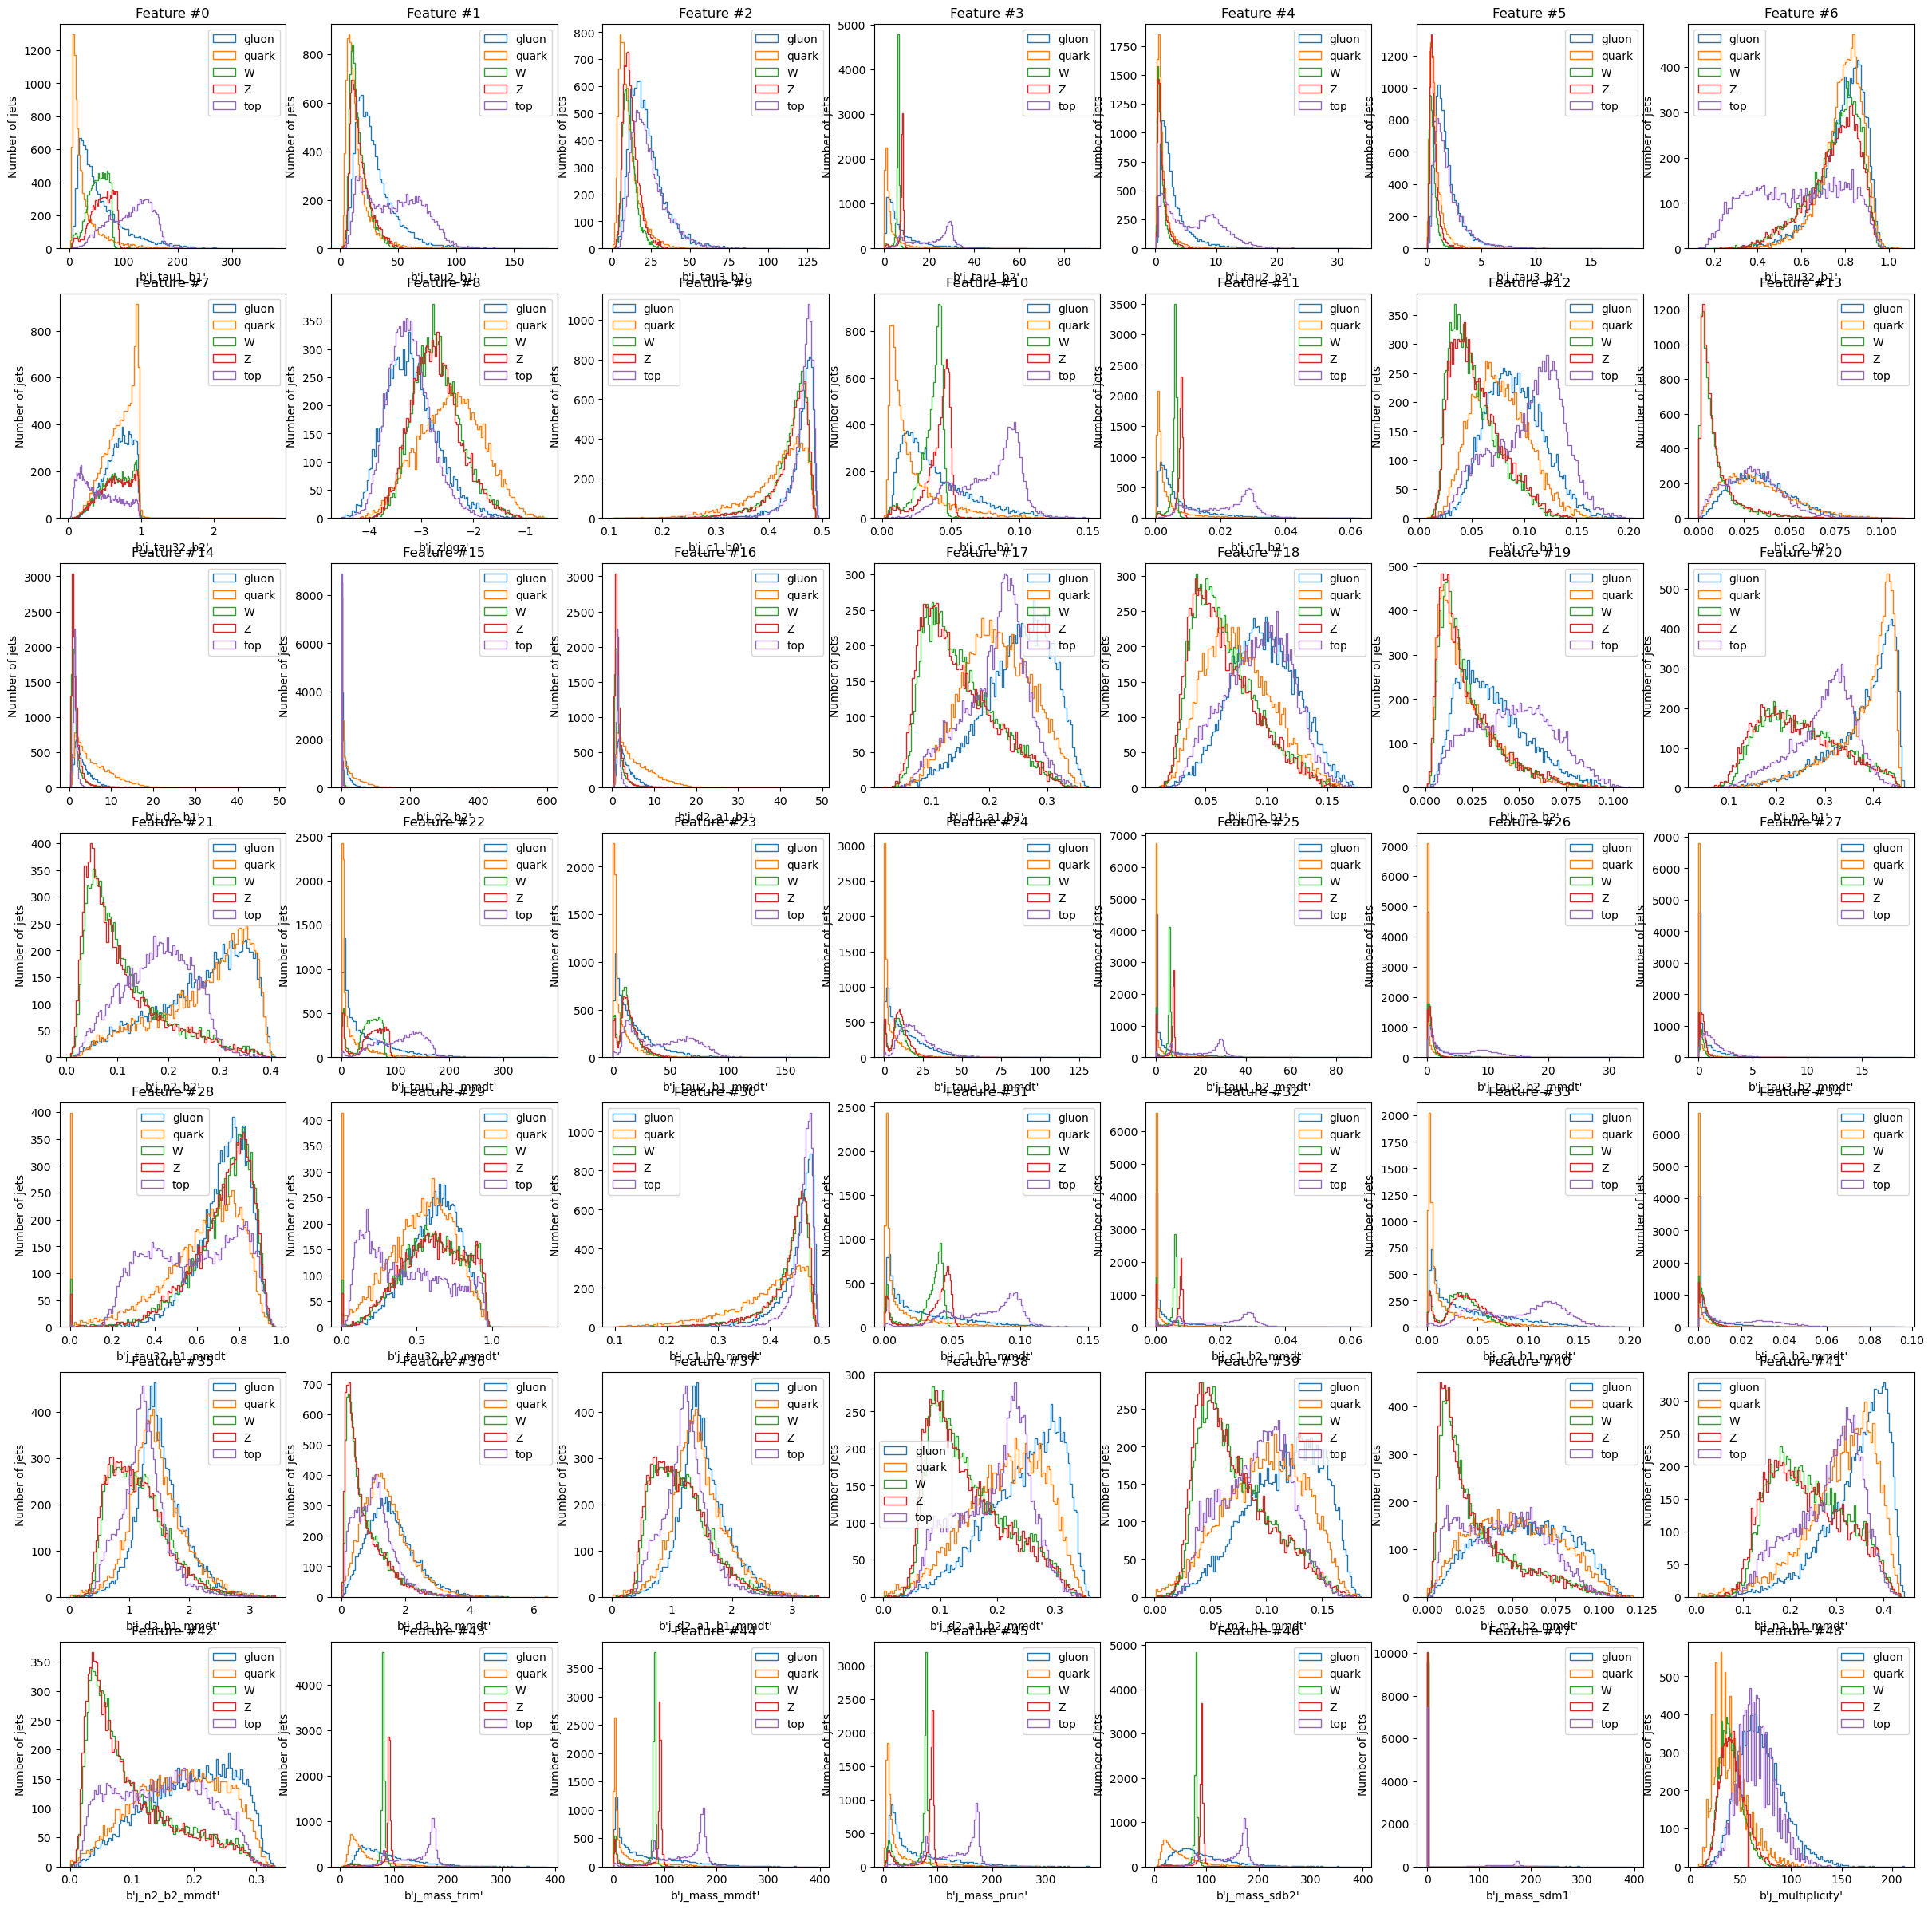

In [5]:
#data exploration
fig, axs = plt.subplots(7, 7, figsize=(30, 30))
for i_feat, feat in enumerate(features_list):
    row, col = i_feat//len(axs[0]),i_feat%len(axs[0])
    for i, label in enumerate(labels):
        axs[row, col].hist(AllFeatures[target[:,i]==1][:,i_feat], bins=100, histtype='step', label=label)
        # plt.hist(AllFeatures[target[:,i]==1][:,30], bins=50, range=(0,0.5), histtype='step', label=label)
    axs[row, col].legend()
    axs[row, col].set_xlabel(feat)
    axs[row, col].set_ylabel('Number of jets')
    axs[row, col].set_title(f'Feature #{i_feat}')

In [6]:
#feature selection
features = AllFeatures[:,[3, 10, 11, 25, 31, 32, 43, 44, 45, 46]]

The dataset consists of 50000 jets, each represented by 16 features

---

We now shuffle the data, splitting them into a training and a validation dataset with 2:1 ratio

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
del features, target

(40000, 10) (10000, 10) (40000, 5) (10000, 5)


# DNN model building

In [8]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [19]:
input_shape = X_train.shape[1]
dropoutRate = 0.01

In [26]:
####
inputArray = Input(shape=(input_shape,))
#
x = Dense(40, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(20)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(10, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(5, activation='relu')(x)
#
output = Dense(5, activation='softmax')(x)
####
model = Model(inputs=inputArray, outputs=output)

In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_10 (Dense)            (None, 40)                440       
                                                                 
 dropout_6 (Dropout)         (None, 40)                0         
                                                                 
 dense_11 (Dense)            (None, 20)                820       
                                                                 
 activation_2 (Activation)   (None, 20)                0         
                                                                 
 dropout_7 (Dropout)         (None, 20)                0         
                                                                 
 dense_12 (Dense)            (None, 10)                210 

We now train the model with these settings:

- the **batch size** is a hyperparameter of gradient descent that controls the number of training samples to work through before the model internal parameters are updated
    - batch size = 1 results in fast computation but noisy training that is slow to converge
    - batch size = dataset size results in slow computation but faster convergence)

- the **number of epochs** controls the number of complete passes through the full training dataset -- at each epoch gradients are computed for each of the mini batches and model internal parameters are updated.

- the **callbacks** are algorithms used to optimize the training (full list [here](https://keras.io/api/callbacks/)):
    - *EarlyStopping*: stop training when a monitored metric (`monitor`) has stopped improving in the last N epochs (`patience`)
    - *ReduceLROnPlateau*: reduce learning rate when a metric (`monitor`) has stopped improving in the last N epochs (`patience`)
    - *TerminateOnNaN*: terminates training when a NaN loss is encountered

In [28]:
batch_size = 1024
n_epochs = 500

# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_split=0.2,
                # callbacks = [
                # EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                # ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                # TerminateOnNaN()]
                )

Epoch 1/500
32/32 - 0s - loss: 5.0315 - val_loss: 1.6747 - 441ms/epoch - 14ms/step
Epoch 2/500
32/32 - 0s - loss: 1.6678 - val_loss: 1.5722 - 51ms/epoch - 2ms/step
Epoch 3/500
32/32 - 0s - loss: 1.6152 - val_loss: 1.5608 - 52ms/epoch - 2ms/step
Epoch 4/500
32/32 - 0s - loss: 1.5779 - val_loss: 1.5010 - 52ms/epoch - 2ms/step
Epoch 5/500
32/32 - 0s - loss: 1.5058 - val_loss: 1.4091 - 52ms/epoch - 2ms/step
Epoch 6/500
32/32 - 0s - loss: 1.4364 - val_loss: 1.3567 - 52ms/epoch - 2ms/step
Epoch 7/500
32/32 - 0s - loss: 1.3879 - val_loss: 1.3217 - 51ms/epoch - 2ms/step
Epoch 8/500
32/32 - 0s - loss: 1.3549 - val_loss: 1.2951 - 51ms/epoch - 2ms/step
Epoch 9/500
32/32 - 0s - loss: 1.3296 - val_loss: 1.2749 - 52ms/epoch - 2ms/step
Epoch 10/500
32/32 - 0s - loss: 1.3077 - val_loss: 1.2556 - 52ms/epoch - 2ms/step
Epoch 11/500
32/32 - 0s - loss: 1.2849 - val_loss: 1.2403 - 52ms/epoch - 2ms/step
Epoch 12/500
32/32 - 0s - loss: 1.2696 - val_loss: 1.2294 - 51ms/epoch - 2ms/step
Epoch 13/500
32/32 - 0s

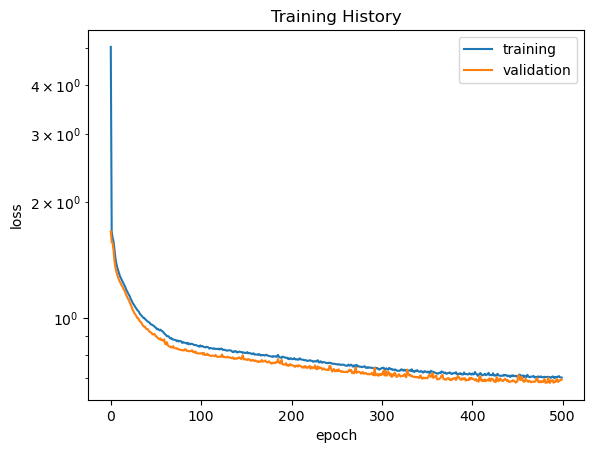

In [29]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

# Building the ROC Curves

313/313 [==============================] - 0s 305us/step


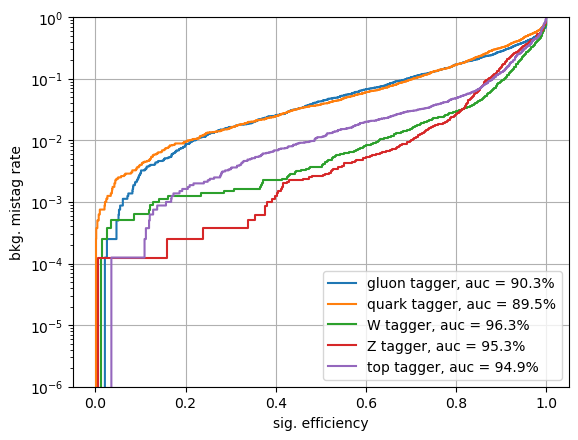

In [30]:
import pandas as pd
from sklearn.metrics import roc_curve, auc
predict_test = model.predict(X_test)
df = pd.DataFrame()
fpr = {}
tpr = {}
auc1 = {}

plt.figure()
for i, label in enumerate(labels):
        df[label] = y_test[:,i]
        df[label + '_pred'] = predict_test[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])

        plt.plot(tpr[label],fpr[label],label='%s tagger, auc = %.1f%%'%(label,auc1[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

## How do you build a QCD vs Top / W / Z ROC curve?

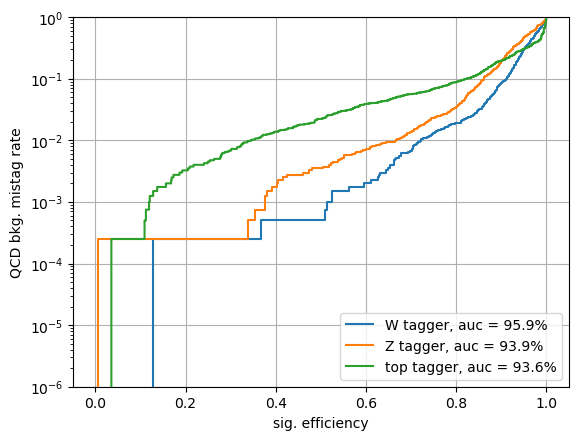

In [31]:
import pandas as pd
from sklearn.metrics import roc_curve, auc

fpr_qcd = {}
tpr_qcd = {}
auc1_qcd = {}

plt.figure()
for i, label in enumerate(labels[2:]):
        qcd_and_signal = (df['gluon']==1) | (df['quark']==1) | (df[label]==1)
        fpr_qcd[label], tpr_qcd[label], threshold = roc_curve(df[label][qcd_and_signal],df[label+'_pred'][qcd_and_signal])

        auc1_qcd[label] = auc(fpr_qcd[label], tpr_qcd[label])

        plt.plot(tpr_qcd[label],fpr_qcd[label],label='%s tagger, auc = %.1f%%'%(label,auc1_qcd[label]*100.))
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("QCD bkg. mistag rate")
plt.ylim(0.000001,1)
plt.grid(True)
plt.legend(loc='lower right')
plt.show()